# Aprendizado Profundo - UFMG

## Preâmbulo

O código abaixo consiste dos imports comuns. Além do mais, configuramos as imagens para ficar de um tamanho aceitável e criamos algumas funções auxiliares. No geral, você pode ignorar a próxima célula.

In [5]:
!pip install mxnet-cu100==1.4.1

     |████████████████████████████████| 488.3MB 32kB/s 
     |████████████████████████████████| 13.8MB 34.9MB/s 
ERROR: spacy 2.1.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.57 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: cvxpy 1.0.24 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Found existing installation: 

In [0]:
# -*- coding: utf8

import matplotlib.pyplot as plt

import mxnet as mx
from mxnet import autograd
import mxnet.ndarray as nd

import numpy as np

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [0]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

Para testar o resultado dos seus algoritmos vamos usar o módulo testing do numpy.

In [0]:
from numpy.testing import assert_equal
from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
import math

## Aula 02 - Regressão Linear e Logística from Scratch

Um fator importante de salientar é que embora nosso curso está fazendo uso de mxnet nas aulas iniciais, vamos migrar para outros frameworks estilo PyTorch ao longo das aulas. No fim, todos são bem parecidos e aplicam as mesmas ideias de diferenciação automática. Para brincar um pouco mais com essa diferenciação, nesta aula vamos implementar a regressão linear e logística do zero. Vamos fazer duas versões de cada:

1. Derivando na mão, não é complicado.
2. Derivando com mxnet

## Conjunto de Problemas 1: Mais Derivadas

Antes de entrar na regressão, vamos brincar um pouco de derivadas dentro de funções. Dado dois números `x` and `y`, implemente a função `log_exp` que retorna:

$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$

In [0]:
def log_exp(x, y):
    # implemente
    num = np.exp(x)
    dem = num + np.exp(y)
    result = -1*np.log(num/dem)
    return result
    pass

1. Abaixo vamos testar o seu código com algumas entradas simples.

In [14]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z

array([[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[
[1.3132617]
<NDArray 1 @cpu(0)>]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]], dtype=object)

In [0]:
# Teste. Não apague
assert_equal(1.31326175, z)

2. Agora implementa uma função para computar $\partial z/\partial x$ e $\partial z/\partial y$ usando `autograd`.

In [0]:
# O argumento funcao_forward é uma função python. Será a sua log_exp.
# A ideia aqui é deixar claro a ideia de forward e backward propagation, depois
# de avaliar a função chamamos backward e temos as derivadas.

def grad(funcao_forward, x, y):
    x.attach_grad()
    y.attach_grad()
    with mx.autograd.record():
        z = funcao_forward(x, y)
    z.backward()
    return x.grad, y.grad

Testando

In [55]:
x, y = nd.array([2]), nd.array([3])
dx, dy = grad(log_exp, x, y)

AttributeError: ignored

In [56]:
assert_equal(-0.7310586, dx.asnumpy())
assert_equal(0.7310586, dy.asnumpy())

NameError: ignored

4. Agora teste com números maiores, algum problema?

In [57]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)

AttributeError: ignored

5. Pense um pouco sobre o motivo do erro acima. Usando as propriedade de logaritmos, é possível fazer uma função mais estável? Implemente a mesma abaixo. O problema aqui é que o exponencial "explode" quando x ou y são muito grandes. Use o [link](http://www.wolframalpha.com/input/?i=log[e%5Ex+%2F+[e%5Ex+%2B+e%5Ey]]) para lhe ajudar.

In [0]:
def stable_log_exp(x, y):
  
  # vamos implementar a forma alternativa do wolfram alfa:
  # e usar a propriedade do logaritmo para evitar colocar as variáveis no denominador.
  
  # o -1 é cortado com o -1 que surge
  
  return nd.log(nd.exp(y-x) + 1)


dx, dy = grad(stable_log_exp, x, y)

In [59]:
stable_log_exp(x, y)


[50.]
<NDArray 1 @cpu(0)>

In [0]:
# Teste. Não apague
assert_equal(-1, dx.asnumpy())
assert_equal(1, dy.asnumpy())

O exemplo acima mostra um pouco de problemas de estabilidade númerica. às vezes é melhor usar versões alternativas de funções. Isto vai ocorrer quando você ver vários nans na sua frente :-) Claro, estamos assumindo que existe uma outra função equivalente que é mais estável para o computador.

## Conjunto de Problemas 2: Regressão Linear

Agora, vamos explorar uma regressão linear. Embora não vamos fazer uso da logexp acima, a ideia de derivar parcialmente dentro de funções pode nos ajudar. Lembrando da regressão linear, inicialmente temos um conjunto observações representadas como tuplas $(\mathbf{x}_i, y_i)$. Aqui, $\mathbf{x}_i$ é um vetor de atributos. Vamo forçar $\mathbf{x}_{i0} = 1$, capturando assim o intercepto. Além do mais, $\mathbf{x}_{ij}$ quando $j\neq 0$, são os outros atributos de entrada. $y_i$ uma valor real representando uma resposta. Nossa regressão visa capturar:

$$y_i = 1 + \theta_1 x_{i1} + \theta_2 x_{i2} + \cdots + \theta_k x_{if}$$

Lembrando da regressão linear multivariada, podemos representar as equações como uma multiplicação de uma matriz com um vetor

![](./figs/linear.png)

7. Crie uma função de previsao. A mesma recebe uma matrix $\mathbf{X}$ e um vetor de parâmetros $\theta$. Sua função deve retornar um vetor de previsões para cada linha de $\mathbf{X}$. Não use nenhum laço!!

In [0]:
def previsao(X, theta):
  
  print('---------')
  print(theta.shape)
  print(X.shape)
  print('---------')
  y_hat = np.dot(X,theta)
  return y_hat


**Erros quadrados**. Para aprender os parâmetros ótimos da regressão linear, precisamos fazer uso de um modelo de erros quadrados. Em particular nosso objetico é aprender os parâmetros que minimizam a função:

$$L(\mathbf{\theta}) = n^{-1} \sum_i ({\hat{y}_i - y_i})^2$$

Onde $\hat{y}_i$ é uma previsão (vêm da sua função python acima). $y_i$ é o valor real dos dados.

8. Implemente uma função para a média dos os erros quadrados.

In [0]:
def media_erros_quadrados(X, theta, y):
  
  y_hat = previsao(X,theta)
  erro = y_hat - y
  erro = np.power(erro,2)
  return erro.mean() 

9. Agora, crie **DUAS** funções que derivam o erro acima. A primeira deve usar o autograd de mxnet. Lembre-se que temos um vetor de parâmetros $\theta$. Por sorte, você pode fazer derivadas de tais vetores também.

In [0]:
def derivada_mxnet(X, theta, y):
    theta.attach_grad()
    with mx.autograd.record():
        e = media_erros_quadrados(X, theta, y)
    e.backward()
    return theta.grad
  
  
  

10. A segunda versão não usa mxnet. Implemente as derivadas do zero. Nos [slides](https://docs.google.com/presentation/d/1bz3G3fEohNtvERKSDtThfGPYOjF83Fzy2yHPdCAlFZw/edit#slide=id.g584f66d2ae_3_74) do link explicamos como fazer tal operação.

In [0]:
x, y = nd.array([2]), nd.array([3])
def derivada_navera(X, theta, y):
    # pelo slide, temos : ((y - X @ 𝛉) * X.T).mean(axis=1)
  
  y_hat = np.dot(X, theta)
  return ((y_hat - y) * X.T).mean(axis=1)
  

  


In [71]:
#x, y = nd.array([2,5,9],[2,3,4]), nd.array([3])


AttributeError: ignored

11. Por fim, otimize sua função usando o algoritmo de gradiente descendente abaixo.

In [0]:
def gd(d_fun, loss_fun, X, y, lambda_=0.01, tol=0.00001, max_iter=10000):
    '''
    Executa Gradiente Descendente. Aqui:
    
    Parâmetros
    ----------
    d_fun : é uma função de derivadas
    loss_fun : é uma função de perda
    X : é um vetor de fatores explanatórios.
        Copie seu código de intercepto da primeira aula.
        para adicionar o intercepto em X.
    y : é a resposta
    lambda : é a taxa de aprendizad
    tol : é a tolerância, define quando o algoritmo vai parar.
    max_ter : é a segunda forma de parada, mesmo sem convergir
              paramos depois de max_iter iterações.
    '''
    theta = nd.random.normal(shape=X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = d_fun(X, theta, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        print( 'theta:')
        print(theta.shape)
        err_sq = loss_fun(X, theta, y)
        if nd.abs(old_err_sq - err_sq) <= tol:
            break
        
        # Atualizar parâmetros e erro
        theta = theta_novo
        old_err_sq = err_sq
        
        # Informação de debug
        print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta

In [0]:
# Para testes, não apague!!!
X = nd.zeros(shape=(1000, 2))
X[:, 0] = 1
X[:, 1] = nd.random.normal(shape=1000)

theta_0_real = 7
theta_1_real = 9
y = theta_0_real + theta_1_real * X[:, 1]

In [98]:
# Sua função deve retornar algo perto de 7 e 9
theta = gd(derivada_mxnet, media_erros_quadrados, X, y)
print(X.shape)
print(y.shape)

# não funciana !!! 

Iter 0; theta =  
[0.02482807 0.00955429]
<NDArray 2 @cpu(0)>
---------
(2,)
(1000, 2)
---------


ValueError: ignored

In [99]:
theta

NameError: ignored

In [100]:
# Sua função deve retornar algo perto de 7 e 9
theta = gd(derivada_navera, media_erros_quadrados, X, y)

Iter 0; theta =  
[1.8973863  0.07713585]
<NDArray 2 @cpu(0)>


ValueError: ignored

In [101]:
theta

NameError: ignored

12. Altere a função de Gradiente Descendente para funcionar com minibatches. Em outras palavras, não compute o erro usando todos os dados de X. Use um `slice` de tamanho do minibatch. Uma ideia é seguir o pseudocódigo abaixo.

```python
index = np.arange(len(X))
while True:
    minib = np.random.choice(index, minibatchsize) # aqui estou usando numpy para selection minibatch elementos
    X_batch = X[minib]
```

In [102]:
# Exemplo abaixo
index = np.arange(len(X))
mb = np.random.choice(index, 50)
print(mb)
X[mb]

[129 674 718 750 978 520 110 362 451  23 983 419 280 975 358 667 977 314
 855 204 927 986 844 793 925 420 915 289 861 779 334 397 181   0 702 246
 145 984 572 402   0  86 603 656 670  26 424 391 814  13]



[[ 1.          0.19974385]
 [ 1.         -1.9411068 ]
 [ 1.          0.9539557 ]
 [ 1.         -0.948489  ]
 [ 1.          1.915245  ]
 [ 1.         -0.29915735]
 [ 1.         -1.4029186 ]
 [ 1.         -0.25764543]
 [ 1.          0.60254997]
 [ 1.         -1.7933522 ]
 [ 1.          0.76667434]
 [ 1.          0.14087798]
 [ 1.          3.3397725 ]
 [ 1.          0.22554377]
 [ 1.         -1.6922293 ]
 [ 1.         -0.26389077]
 [ 1.          0.71739316]
 [ 1.          0.03267157]
 [ 1.          1.4719718 ]
 [ 1.          0.98257786]
 [ 1.         -1.711995  ]
 [ 1.         -0.25520158]
 [ 1.          0.5188873 ]
 [ 1.          1.6633134 ]
 [ 1.         -0.5735055 ]
 [ 1.         -0.6291476 ]
 [ 1.         -1.5017413 ]
 [ 1.         -0.04136932]
 [ 1.         -1.112209  ]
 [ 1.          0.67873055]
 [ 1.          2.2524652 ]
 [ 1.          1.0827469 ]
 [ 1.         -0.15245853]
 [ 1.         -0.11660124]
 [ 1.          1.272896  ]
 [ 1.         -0.53421515]
 [ 1.          1.1491399 ]


In [0]:
def minibatch_gd(d_fun, loss_fun, X, y, lambda_=0.01, tol=0.00001,
                 max_iter=10000, batch_size=10):
    '''
    Executa Gradiente Descendente. Aqui:
    
    Parâmetros
    ----------
    d_fun : é uma função de derivadas
    loss_fun : é uma função de perda
    X : é um vetor de fatores explanatórios.
        Copie seu código de intercepto da primeira aula.
        para adicionar o intercepto em X.
    y : é a resposta
    lambda : é a taxa de aprendizad
    tol : é a tolerância, define quando o algoritmo vai parar.
    max_ter : é a segunda forma de parada, mesmo sem convergir
              paramos depois de max_iter iterações.
    batch_size : tamanho do batch
    '''
    # implemente

    theta = nd.random.normal(shape=X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    
    index = np.arange(len(X))
    while True:
        # pega o mini batch
        mb = np.random.choice(index, 50)
        Xmb = X[mb]
        ymb = y[mb]
        
        # Computar as derivadas
        grad = d_fun(Xmb, theta, ymb)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err_sq = loss_fun(Xmb, theta, ymb)
        if nd.abs(old_err_sq - err_sq) <= tol:
            break
        
        # Atualizar parâmetros e erro
        theta = theta_novo
        old_err_sq = err_sq
        
        # Informação de debug
        print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta
    
    
    


In [105]:
# Sua função deve retornar algo perto de 7 e 9
minibatch_gd(derivada_mxnet, media_erros_quadrados, X, y)

Iter 0; theta =  
[0.40762472 0.8238177 ]
<NDArray 2 @cpu(0)>
---------
(2,)
(50, 2)
---------


ValueError: ignored

## Conjunto de Problemas 3: Logistic from Scratch

12. Repita o mesmo processo para a Logística. Lembrando que a mesma tem a seguinte forma:

$$f(x_i) = \frac{1}{1 + e^{-(1 + \theta_1 x_{i1} + \theta_2 x_{i2} + \cdots \theta_k x_{ik})}}$$

Implemente a função logística.

In [0]:
def logistic(X, theta):
  ex = nd.dot(X, theta)
  res = 1.0/ (1 + np.exp(ex))
  return res

In [107]:
# testes, não apague!
X_teste = nd.random.normal(shape=(1000, 20000))
theta = nd.random.normal(shape=(20000))
y_hat_teste = logistic(X_teste, theta)
assert_equal(True, (y_hat_teste >= 0).asnumpy().all())
assert_equal(True, (y_hat_teste <= 1).asnumpy().all())

AttributeError: ignored

Usando a logística acima implemente uma função logistica_prever que retorna 0 ou 1. Use o limar dado na função. 

In [0]:
def logistica_prever(X, theta, limiar=0.5):
  vero = logistic(X, theta)
  return vero> limiar
  

In [109]:
# testes, não apague!
X_teste = nd.random.normal(shape=(1000, 20000))
theta = nd.random.normal(shape=(20000))
y_hat_teste = logistica_prever(X_teste, theta)
for yi in y_hat_teste.asnumpy():
    assert(yi in {0, 1})

AttributeError: ignored

Agora, implemente uma função de entropia cruzada da logística. A mesma, é proporcional ao inverso da verossimilhança. Para entender a derivação entre as duas faça uso dos [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing). 

Sendo:

$$ll(x_i,y_i~|~\theta) = y_i \log f(x_i\theta) + (1-y_i) \log (1-f(x_i\theta))$$

A verossimilhança para uma observação. A entropia cruzada é a media da negação do termo para todos os exemplos:

$$L(\theta) = -n^{-1}\sum_i \big((1-y_i)\log (1-f_{\theta}(x_i)) + y_i\log (f_{\theta}(x_i))\big)$$

`dica: use nd.clip(logistic(X, theta), 0.001, 0.999)`. A função remove os 0 e 1s da logistic, evitando assim o valor log(0).

In [0]:
def cross_entropy_mean(X, theta, y):
    vero = logistic(X, theta)
    logit = nd.clip(vero, 0.00001, 0.99999)
    return -(y * nd.log(logit) + (1 - y) * nd.log(1 - logit)).mean()

In [111]:
# testes, não apague!
from sklearn import datasets
state = np.random.seed(20190187)

X, y = datasets.make_blobs(n_samples=200, n_features=2, centers=2)
X = nd.array(X)
y = nd.array(y)

for _ in range(100):
    theta = nd.random.normal(shape=(2, ))
    assert(cross_entropy_mean(X, theta, y) >= 0)

AssertionError: ignored

Agora implemente a derivada.

In [0]:
def derivada_mxnet_logit(X, theta, y):
    theta.attach_grad()
    with mx.autograd.record():
        e = cross_entropy_mean(X, theta, y)
    e.backward()
    return theta.grad

A partir daqui basta executar código.

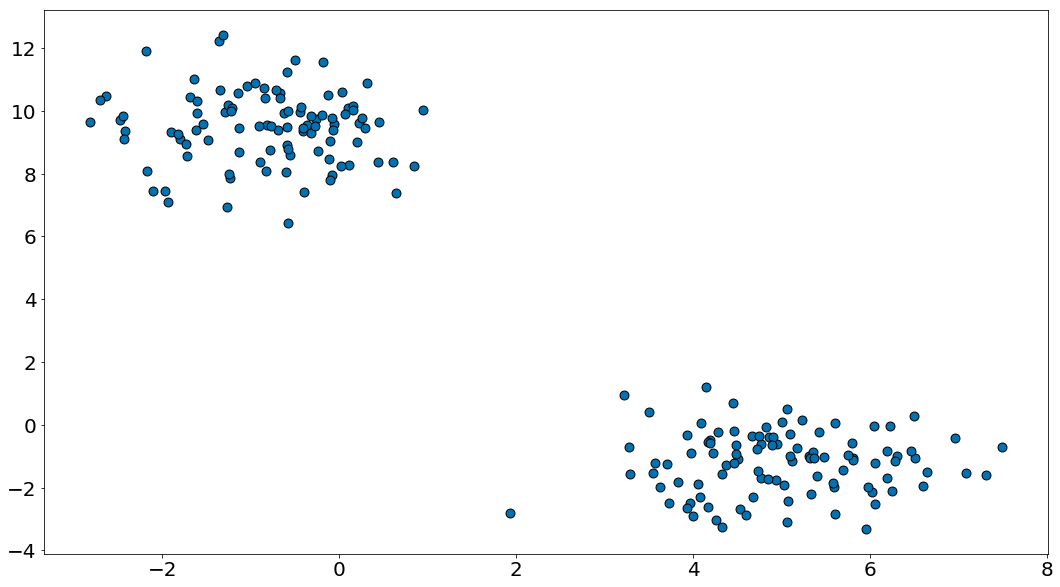

In [113]:
plt.scatter(X.asnumpy()[:, 0], X.asnumpy()[:, 1], s=80, edgecolors='k')

13. Assim como foi feito na primeira aula, abaixo testamos o seu código com um toy dataset.

In [0]:
# Use essa função antes de executar o GD
def add_intercept(X):
    Xn = nd.zeros(shape=(X.shape[0], X.shape[1] + 1))
    Xn[:, 0]  = 1
    Xn[:, 1:] = X
    return Xn

In [115]:
Xn = add_intercept(X)

theta = minibatch_gd(derivada_mxnet_logit, cross_entropy_mean, Xn, y)

Iter 0; theta =  
[ 1.344402    0.47553363 -0.5752262 ]
<NDArray 3 @cpu(0)>


AssertionError: ignored

In [116]:
y_p = logistica_prever(Xn, theta)
print((y == y_p).mean())

MXNetError: ignored